#### Makeing the Kymograph Code Interactive

Xref: Journal/10_15_18/generate_kymograph.ipynb


Let's copy everything useful from that notebook....

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import h5py
import seaborn as sns
import scipy.signal
import shutil
import skimage as sk
from skimage import filters

import dask
from dask.distributed import Client,progress
from dask_jobqueue import SLURMCluster
import time
import os
matplotlib.rcParams['figure.figsize'] = [20, 10]

#### Note: 
 - Really need to time optimize this code. The read/write is killing me at one part...Doesn't cause a problem in the non hdf5 version...
 - generalize to have any number of trenches/lanes
 - Also, a way of handling the metadata would be nice...

In [4]:
## NEED TO HAVE A PARAMETER TUNING INTERFACE, take a look at charles' code?


class kymograph:
    def __init__(self,input_file_prefix,output_path,all_channels,trench_len_y,padding_y,trench_width_x,top_and_bottom=True,\
                 t_chunk=25,y_percentile=85,y_time_percentile=85,smoothing_kernel_y=(9,3),\
                 triangle_nbins=50,x_percentile=85,background_kernel_x=301,smoothing_kernel_x=9,\
                 otsu_nbins=50):
        """The kymograph class is used to generate and visualize kymographs. The central function of this
        class is the method 'generate_kymograph', which takes an hdf5 file of images from a single fov and
        outputs an hdf5 file containing kymographs from all detected trenches.
        
        TEMP_NOTE: * means should be tuned case by case after checking outputs. ** other change to be made
        
        Args:
            input_file_prefix (string): Path prefix (e.x. "./folder/fov_") to the input hdf5 file.
            output_path (string): Directory to write the output file to, this is also where temporary files
            will be written to.
            all_channels (list): list of strings corresponding to the different image channels
            available in the input hdf5 file, with the channel used for segmenting trenches in
            the first position. NOTE: these names must match those of the input hdf5 file datasets.
            temp_path (string): Path to a temporary folder to be used during computation,
            will be created if it does not exist and overwrites any files that start in this
            directory.
            trench_len_y (int): Length from the end of the tenches to be used when cropping in the 
            y-dimension.*
            padding_y (int): Padding to be used when cropping in the y-dimension.*
            trench_width_x (int): Width to be used when cropping in the x-dimension.*
            top_and_bottom (bool): Whether or not to look for top and bottom trenches, or only top.
            NOTE: will change this soon to be more flexible.**
            t_chunk (int): Time chunk to load into memory during computation. Inceasing this number
            will lead to faster processing, but will also increase memory load.*

            All entries below should not be tuned except in special cases...

            y_percentile (int): Used for reducing signal in xyt to only the yt dimension when cropping
            in the y-dimension.*
            y_time_percentile (int): Used for reducing signal in yt dimension to only the y dimension 
            when cropping in the y-dimension.*
            smoothing_kernel_y (tuple): Two-entry tuple specifying a kernel size for smoothing out yt
            signal when cropping in the y-dimension.*
            triangle_nbins (int): Number of bins to use when applying the triangle method to y-dimension signal.

            x_percentile (int): Used for reducing signal in xyt to only the xt dimension when cropping
            in the x-dimension.*
            background_kernel_x (int): Kernel used for performing background subtraction on xt signal when
            cropping in the x-dimension.*
            smoothing_kernel_x (int): Kernel used for performing smoothing on xt signal when cropping
            in the x-dimension.*
            otsu_nbins (int): Number of bins to use when applying Otsu's method to x-dimension signal.

        """
        
        self.input_file_prefix = input_file_prefix
        self.output_path = output_path
        self.temp_dir_prefix = output_path + "/tempfiles_"      

        self.all_channels = all_channels
        self.seg_channel = self.all_channels[0]
        
        if top_and_bottom:
            self.top_bottom_list = ["top","bottom"]
        else:
            self.top_bottom_list = ["top"]
        self.t_chunk = t_chunk
        
        
        #### important paramaters to set
        self.trench_len_y = trench_len_y
        self.padding_y = padding_y
        self.ttl_len_y = trench_len_y+padding_y
        self.trench_width_x = trench_width_x
        self.top_and_bottom = top_and_bottom
        
        #### params for y
        ## parameter for reducing signal to one dim
        self.y_percentile = y_percentile
        ## parameters for threshold finding
        self.y_time_percentile = y_time_percentile
        self.smoothing_kernel_y = smoothing_kernel_y
        self.triangle_nbins = triangle_nbins
        

        #### params for x
        ## parameter for reducing signal to one dim
        self.x_percentile = x_percentile
        ## parameters for midpoint finding
        self.background_kernel_x = background_kernel_x
        self.smoothing_kernel_x = smoothing_kernel_x
        ## parameters for threshold finding
        self.otsu_nbins = otsu_nbins
        
    def writedir(self,directory,overwrite=False):
        """Creates an empty directory at the specified location. If a directory is
        already at this location, it will be overwritten if 'overwrite' is true,
        otherwise it will be left alone. 
        
        Args:
            directory (str): Path to directory to be overwritten/created.
            overwrite (bool, optional): Whether to overwrite a directory that
            already exists in this location.
        """
        if overwrite:
            if os.path.exists(directory):
                shutil.rmtree(directory)
            os.makedirs(directory)
        else:
            if not os.path.exists(directory):
                os.makedirs(directory)
    
    def removefile(self,filepath):
        """Removes a file at the specified path, if it exists.
        
        Args:
            filepath (str): Path to file for deletion.
        """
        if os.path.exists(filepath):
            os.remove(filepath)
    
    def median_filter_1d(self,statistic,kernel):
        """One-dimensional median filter, with average smoothing at the signal edges.
        
        Args:
            statistic (array): One dimensional input signal.
            kernel (int): Kernel size to be used in the median filter.
        
        Returns:
            array: Median-filtered signal.
        """
        kernel_pad = kernel//2 + 1
        med_filter = scipy.signal.medfilt(statistic,kernel_size=kernel)
        start_edge = np.mean(med_filter[kernel_pad:kernel])
        end_edge = np.mean(med_filter[-kernel:-kernel_pad])
        med_filter[:kernel_pad] = start_edge
        med_filter[-kernel_pad:] = end_edge
        return med_filter
    
    def median_filter_2d(self,array_list):
        """Two-dimensional median filter, with average smoothing at the signal edges in
        the first dimension.
        
        Args:
            array_list (list): List containing a single array of yt signal to be smoothed.
        
        Returns:
            array: Median-filtered yt signal.
        """
        kernel = np.array(self.smoothing_kernel_y)
        kernel_pad = kernel//2 + 1
        med_filter = scipy.signal.medfilt(array_list[0],kernel_size=kernel)
        start_edge = np.mean(med_filter[kernel_pad[0]:kernel[0]])
        end_edge = np.mean(med_filter[-kernel[0]:-kernel_pad[0]])
        med_filter[:kernel_pad[0]] = start_edge
        med_filter[-kernel_pad[0]:] = end_edge
        return med_filter
    
    def reassign_idx(self,array,values,indices,axis):
        """Performs in-line value reassignment on numpy arrays, normally handled
        with the array[:,indices] = values syntax, with the ability to supply
        the axis as an argument.
        
        Args:
            array (array): Input array to have values reassigned.
            values (array): New value positions in array.
            indices (array): Positions in the input array to be reassigned.
            axis (int): Axis along which to reassign values.
        """
        str_constructor = "".join((len(array.shape)*[":,"]))[:-1]
        str_constructor = "[" + str_constructor + "]"
        str_constructor = "array"+ str_constructor[:axis*2+1] + "indices" +\
                        str_constructor[axis*2+2:] + " = values"
        exec(str_constructor)
    
    def write_hdf5(self,file_name,array,ti,t_len,t_dim_out,dataset_name):
        """Writes an array to a particular dataset in an hdf5 file. Positions
        in time are left variable to enable chunking the dataset in time.
        
        Args:
            file_name (str): Name of the hdf5 file, assumed to be in the temp folder
            initialized by this class.
            array (array): Array to be written.
            ti (int): Initial time position to write array values to.
            t_len (int): Total size of the target time dimension.
            t_dim_out (int): Axis of the target time dimension.
            dataset_name (str): The name of the hdf5 dataset to write to.
        """
        with h5py.File(self.temp_path + file_name + ".hdf5", "a") as h5pyfile:
            indices = list(range(ti,min(ti+self.t_chunk,t_len)))
            self.reassign_idx(h5pyfile[dataset_name],array,indices,t_dim_out)

    def delete_hdf5(self,file_handle):
        """Deletes an hdf5 file, given its file handle, and closes the handle
        itself.
        
        Args:
            file_handle (hdf5file): Hdf5 file handle.
        """
        filepath = file_handle.filename
        file_handle.close()
        self.removefile(filepath)
        
    def init_hdf5(self,file_name,dataset_name,array,t_len,t_dim_out):
        """Initializes an empty hdf5 file and dataset to write to, given an array
        with the target shape in all axes but the time axis. The time axis
        is then specified by t_len.

        Args:
            file_name (str): Name of the hdf5 file, assumed to be in the temp folder
            initialized by this class.
            dataset_name (str): The name of the hdf5 dataset to initialize.
            array (array): Array which is of the same size as the dataset,
            except in the time dimension.
            t_len (int): Total size of the dataset time dimension.
            t_dim_out (int): Axis of the dataset time dimension.
        """
        out_shape = list(array.shape)
        out_shape[t_dim_out] = t_len
        out_shape = tuple(out_shape)
        with h5py.File(self.temp_path + file_name + ".hdf5", "a") as h5pyfile:
            hdf5_dataset = h5pyfile.create_dataset(dataset_name , out_shape, dtype='uint16')
                
    def chunk_t(self,hdf5_array_list,t_dim_in_list,t_dim_out,function,file_name,dataset_name,*args):
        """Applies a given function to any number of input hdf5 arrays, chunking this processing in the
        time dimension, and outputs another hdf5 file.
        
        Args:
            hdf5_array_list (list): List of input arrays to be operated on by the function.
            t_dim_in_list (list): List of ints that specify the time axis of each input array.
            t_dim_out (int): Specifies the time axis of the output array.
            function (function): Function to apply to the input arrays (must be ready to take a list of
            arrays as input.
            file_name (str): Name of the output hdf5 file, assumed to be in the temp folder
            initialized by this class.
            dataset_name (str): The name of the hdf5 dataset to write to.
            *args: Extra arguments to be passed to the function, that do not need to be chunked in time.
        
        Returns:
            hdf5file: Hdf5 file handle corresponding to the output array.
        """
        t_len = hdf5_array_list[0].shape[t_dim_in_list[0]]
        for ti in range(0,t_len,self.t_chunk):
            indices = list(range(ti,min(ti+self.t_chunk,t_len)))                
            chunk_list = [np.take(hdf5_array_list[i], indices, axis=t_dim_in_list[i]) for i in range(len(hdf5_array_list))]
            f_chunk = function(chunk_list,*args)
            if ti == 0:
                self.init_hdf5(file_name,dataset_name,f_chunk,t_len,t_dim_out)
            self.write_hdf5(file_name,f_chunk,ti,t_len,t_dim_out,dataset_name)
        out_hdf5_handle = h5py.File(self.temp_path + file_name + ".hdf5", "r")
        return out_hdf5_handle

    def import_hdf5(self,t_dim_in,t_dim_out,file_name,dataset_name):
        """Stripped down version of 'self.chunk_t' that performs initial import of the hdf5 file to be
        processed. Simply converts the input hdf5 file's "channel" datasets into the first dimension
        of the array, ordered as specified by 'self.all_channels'
        
        Args:
            t_dim_in (int): Specifies the time axis of the input array.
            t_dim_out (int): Specifies the time axis of the output array.
            file_name (str): Name of the output hdf5 file, assumed to be in the temp folder
            initialized by this class.
            dataset_name (str): The name of the hdf5 dataset to write to.
        
        Returns:
            hdf5file: Hdf5 file handle corresponding to the output array.
        """
        t_len = self.hdf5file[self.seg_channel].shape[t_dim_in]
        for ti in range(0,t_len,self.t_chunk):
            indices = list(range(ti,min(ti+self.t_chunk,t_len)))
            chunk_array = np.array([np.take(self.hdf5file[channel], indices, axis=t_dim_in) for channel in self.all_channels])
            if ti == 0:
                self.init_hdf5(file_name,dataset_name,chunk_array,t_len,t_dim_out)
            self.write_hdf5(file_name,chunk_array,ti,t_len,t_dim_out,dataset_name)
        out_hdf5_handle = h5py.File(self.temp_path + file_name + ".hdf5", "r")
        return out_hdf5_handle
    
    def get_y_percentile(self,array_list):
        """Converts an input xyt array to a yt array using a percentile cutoff.
        
        Args:
            array_list (list): Singleton list containing input array.
        
        Returns:
            array: Output yt array.
        """
        return np.percentile(array_list[0],self.y_percentile,axis=1)

    def crop_y(self,array_list):
        """Performs cropping of the images in the y-dimension (may be possible to shorten/split this?)
        
        Args:
            array_list (list): List of arrays containing [smoothed yt signal, input image hdf5 array]
        
        Returns:
            array: Cropped output array.
        """
        y_percentiles_smoothed = array_list[0]
        img_arr = array_list[1]
        y_time_percentile = np.percentile(y_percentiles_smoothed,self.y_time_percentile,axis=1)
        
        triangle_threshold = sk.filters.threshold_triangle(y_time_percentile[:,np.newaxis],nbins=self.triangle_nbins)
        trench_mask_y = y_percentiles_smoothed>triangle_threshold

        time_list = []
        for t in range(trench_mask_y.shape[1]):
            trench_edge_mask = (trench_mask_y[1:,t] != trench_mask_y[:-1,t])
            trench_edges_y = np.where(trench_edge_mask)[0]
            
            if self.top_and_bottom:
                top_trench_edge_y = trench_edges_y[0]
                top_upper = max(top_trench_edge_y-self.padding_y,0)
                top_lower = min(top_trench_edge_y+self.trench_len_y,trench_mask_y.shape[0])

                bottom_trench_edge = trench_edges_y[-1]
                bottom_upper = max(bottom_trench_edge-self.trench_len_y,0)
                bottom_lower = min(bottom_trench_edge+self.padding_y,trench_mask_y.shape[0])

                channel_list = []
                for i,channel in enumerate(self.all_channels):
                    output_array = img_arr[i,:,:,t]
                    top_bottom_list = [output_array[top_upper:top_lower],output_array[bottom_upper:bottom_lower]]
                    channel_list.append(top_bottom_list)
                time_list.append(channel_list)
            else:
                top_trench_edge_y = trench_edges_y[0]
                top_upper = max(top_trench_edge_y-self.padding_y,0)
                top_lower = min(top_trench_edge_y+self.trench_len_y,trench_mask_y.shape[0])
                
                channel_list = []
                for channel in self.all_channels:
                    output_array = img_arr[i,:,:,t]
                    top_bottom_list = [output_array[top_upper:top_lower]]
                    channel_list.append(top_bottom_list)
                time_list.append(channel_list)
                
        cropped_in_y = np.array(time_list)
        cropped_in_y = np.moveaxis(cropped_in_y,(0,1,2,3,4),(4,1,0,2,3))
        return cropped_in_y
        
    def crop_trenches_in_y(self,imported_hdf5_handle):
        """Master function for cropping the input hdf5 file in the y-dimension.
        
        Args:
            imported_hdf5_handle (hdf5file): File handle for the imported hdf5 file.
        
        Returns:
            hdf5file: File handle for the output y-cropped hdf5 file.
        """
        y_percentiles_handle = self.chunk_t([imported_hdf5_handle["data"][0]],[2],1,self.get_y_percentile,"y_percentile","data")
        y_percentiles_smoothed_handle = self.chunk_t([y_percentiles_handle["data"]],[1],1,self.median_filter_2d,"y_percentile_smoothed","data")
        self.delete_hdf5(y_percentiles_handle)
        all_cropped_in_y_handle = self.chunk_t([y_percentiles_smoothed_handle["data"],imported_hdf5_handle["data"]],[1,3],4,self.crop_y,"cropped_in_y","data")
        self.delete_hdf5(y_percentiles_smoothed_handle)
        if len(all_cropped_in_y_handle['data'].shape) != 5: #this is a stopgap for more complex problems
            return None
        return all_cropped_in_y_handle
    
    def get_midpoints_from_mask(self,mask):
        """Using a boolean x mask, computes the positions of trench midpoints.
        
        Args:
            mask (array): x boolean array, specifying where trenches are present.
        
        Returns:
            array: array of trench midpoint x positions.
        """
        transitions = mask[:-1].astype(int) - mask[1:].astype(int)
        
        trans_up = np.where((transitions==-1))[0]
        trans_dn = np.where((transitions==1))[0]
                
        if len(np.where(trans_dn>trans_up[0])[0])>0:
            first_dn = np.where(trans_dn>trans_up[0])[0][0]
            trans_dn = trans_dn[first_dn:]
            trans_up = trans_up[:len(trans_dn)]
            midpoints = (trans_dn + trans_up)//2
        else:
            midpoints = []
        return midpoints
    
    def get_midpoints(self,x_percentile):
        """Given an array of signal in x, determines the position of trench midpoints.
        
        Args:
            x_percentile (array): array of trench intensities in x.
        
        Returns:
            array: array of trench midpoint x positions.
        """
        background_filtered = x_percentile - self.median_filter_1d(x_percentile,self.background_kernel_x)
        smooth_filtered = self.median_filter_1d(background_filtered,self.smoothing_kernel_x)
        
        otsu_threshold = sk.filters.threshold_otsu(smooth_filtered[:,np.newaxis],nbins=self.otsu_nbins)
        x_mask = smooth_filtered>otsu_threshold

        midpoints = self.get_midpoints_from_mask(x_mask)
        return midpoints
    
    def get_all_midpoints(self,all_cropped_in_y_handle,top_bottom,channel):
        """Given a file handle for images cropped in y, finds all midpoints in time for a given
        trench row (top/bottom) and channel.
        
        Args:
            all_cropped_in_y_handle (hdf5file): File handle for the output y-cropped hdf5 file.
            top_bottom (int): Int specifying whether we are looking at the top (0) or bottom (1) trench.
            channel (int): Int specifying which channel we are getting midpoints from (order specified by
            self.all_channels).
        
        Returns:
            array: array of midpoints of shape (t_dim,x_dim)
        """
        cropped_in_y = all_cropped_in_y_handle['data']
        all_midpoints = []
        x_percentile = np.percentile(cropped_in_y[top_bottom,channel,:,:,0],self.x_percentile,axis=0)
        midpoints = self.get_midpoints(x_percentile)
        if len(midpoints) == 0:
            return None
        all_midpoints.append(midpoints)
        for t in range(1,self.t_dim):
            x_percentile = np.percentile(cropped_in_y[top_bottom,channel,:,:,t],self.x_percentile,axis=0)
            midpoints = self.get_midpoints(x_percentile)
            if len(midpoints)/(len(all_midpoints[-1])+1) < 0.5:
                all_midpoints.append(all_midpoints[-1])
            else:
                all_midpoints.append(midpoints)
        all_midpoints = np.array(all_midpoints)
        return all_midpoints

    def get_x_drift(self,all_midpoints):
        """Given an t by x array of midpoints, computed the average drift in x for every timepoint.
        
        Args:
            all_midpoints (array): array of midpoints of shape (t_dim,x_dim).
        
        Returns:
            array: t length array of x drift values over time.
        """
        x_drift = []
        for t in range(len(all_midpoints)-1):
            diff_mat = np.subtract.outer(all_midpoints[t+1],all_midpoints[t])
            min_dist_idx = np.argmin(abs(diff_mat),axis=0)
            min_dists = diff_mat[min_dist_idx]
            median_translation = int(np.median(min_dists))
            x_drift.append(median_translation)
        net_x_drift = np.append(np.array([0]),np.add.accumulate(x_drift))
        return net_x_drift

    def init_counting_arr(self):
        """Initializes a counting array of shape (x_dim,t_dim) which counts from 0 to
        x_dim on axis 0 for all positions in axis 1.
        
        Returns:
            array: Counting array to be used for masking out trenches in x.
        """
        ones_arr = np.ones(self.x_dim)
        counting_arr = np.add.accumulate(np.ones(self.x_dim)).astype(int) - 1
        counting_arr_repeated = np.repeat(counting_arr[:,np.newaxis],self.t_chunk,axis=1)
        return counting_arr_repeated

    def get_k_mask(self,in_bounds_list,counting_arr,k):
        """Generates a boolean trench mask of shape (x_dim,t_dim) for a given trench k, using
        the trench boundary values in in_bounds_list.
        
        Args:
            in_bounds_list (list): Singleton list containing the in_bounds array, which is a shape (2,t_dim,k_dim)
            array specifying the start and end bounds in x of a given trench k over time.
            counting_arr (array): Counting array to be used for masking out trenches in x.
            k (int): Int specifying the trench to generate a mask for.
        
        Returns:
            array: Boolean trench mask of shape (x_dim,t_dim) for a given trench k.
        """
        in_bounds = in_bounds_list[0]
        working_t_dim = in_bounds.shape[1]
        cropped_counting_arr = counting_arr[:,:working_t_dim]
        k_mask = np.logical_and(cropped_counting_arr>in_bounds[0,:,k],cropped_counting_arr<in_bounds[1,:,k]).T
        return k_mask
    
    def apply_kymo_mask(self,array_list,top_bottom,channel):
        """Given a y-cropped image and a boolean trench mask of shape (x_dim,t_dim), masks that image in
        xt to generate an output kymograph of shape (y_dim,x_dim,t_dim). 
        
        Args:
            array_list (list): List containing two arrays: 1) An hdf5 array of a y-cropped image
            2) A boolean trench mask of shape (x_dim,t_dim) for a given trench k.  
            top_bottom (int): Int specifying whether we are looking at the top (0) or bottom (1) trench.
            channel (int): Int specifying which channel we are getting midpoints from (order specified by
            self.all_channels).
        
        Returns:
            array: Kymograph array of shape (y_dim,x_dim,t_dim).
        """
        img_arr,mask_arr = tuple(array_list)
        working_img_arr = img_arr[top_bottom,channel]
        reshaped_arr = np.swapaxes(working_img_arr,1,2)
        masked_arr = reshaped_arr[:,mask_arr.astype(bool)]
        reshaped_masked_arr = masked_arr.reshape(reshaped_arr.shape[0],reshaped_arr.shape[1],-1)
        swapped_masked_arr = np.swapaxes(reshaped_masked_arr,1,2)
        return swapped_masked_arr
        
    def crop_in_x(self,all_cropped_in_y_handle,top_bottom,top_bottom_i,all_midpoints,x_drift):
        """Given a y-cropped hdf5 file, detected midpoints and the estimated drift in x, generates
        complete kymograph files for all trenches in the fov in every channel listed in 'self.all_channels'.
        A single hdf5 file is written for the fov containing datasets of the format top_bottom/channel/trench_k.
        
        Args:
            all_cropped_in_y_handle (hdf5file): File handle for a y-cropped hdf5 file.
            top_bottom (str): str specifying whether we are working with the top or bottom trench.
            top_bottom_i (int): Int specifying whether we are looking at the top (0) or bottom (1) trench.
            all_midpoints (array): array of midpoints of shape (t_dim,x_dim)
            x_drift (array): t length array of x drift values over time.
        """
        corrected_midpoints = x_drift[:,np.newaxis]+all_midpoints[0][np.newaxis,:]
        midpoints_up,midpoints_dn = (corrected_midpoints-self.trench_width_x//2,\
                                     corrected_midpoints+self.trench_width_x//2+1)
        valid_mask = np.all(midpoints_up>=0,axis=0)*np.all(midpoints_dn<=self.x_dim,axis=0)
        in_bounds = np.array([midpoints_up[:,valid_mask],\
                            midpoints_dn[:,valid_mask]])
        counting_arr = self.init_counting_arr()
        k_mask_file_name = "k_mask_" + str(top_bottom)
        for k in range(in_bounds.shape[2]):
            k_mask_handle = self.chunk_t([in_bounds],[1],0,self.get_k_mask,k_mask_file_name,str(k),counting_arr,k)
            k_mask_handle.close()
            
        k_mask_handle = h5py.File(self.temp_path + k_mask_file_name + ".hdf5", "r")
        
        for j,channel in enumerate(self.all_channels):
            kymograph_handles = []
            for k in range(in_bounds.shape[2]):
                dataset_name = str(top_bottom) + "/" + str(channel) + "/" + str(k)
                kymograph_handle = self.chunk_t([all_cropped_in_y_handle['data'],k_mask_handle[str(k)]],[4,0],2,\
                                self.apply_kymo_mask,"output",dataset_name,top_bottom_i,j)
                kymograph_handle.close()

        self.delete_hdf5(k_mask_handle)
                
    def generate_kymograph(self,fov):
        """Master function for generating kymographs for the target fov. A single hdf5 file is written for the fov
        containing datasets of the format top_bottom/channel/trench_k. If nothing is written, this function 
        returns None.
        
        fov (int): The particular field of view (fov) to generate kymographs from.

        """
        self.writedir(self.output_path,overwrite=False)
        self.temp_path = self.temp_dir_prefix + str(fov) + "/"
        self.writedir(self.temp_path,overwrite=True)
        self.hdf5file = h5py.File(self.input_file_prefix + str(fov) + ".hdf5", "a")
        self.y_dim,self.x_dim,self.t_dim = self.hdf5file[self.seg_channel].shape
        
        imported_hdf5_handle = self.import_hdf5(2,3,"imported_hdf5","data")
        all_cropped_in_y_handle = self.crop_trenches_in_y(imported_hdf5_handle)
        if all_cropped_in_y_handle is None:
            return None
                
        for i,top_bottom in enumerate(self.top_bottom_list):
            all_midpoints = self.get_all_midpoints(all_cropped_in_y_handle,i,0)
            if all_midpoints is None:
                continue
            else:
                x_drift = self.get_x_drift(all_midpoints)
                self.crop_in_x(all_cropped_in_y_handle,top_bottom,i,all_midpoints,x_drift)
        output_file_path = self.temp_path + "output.hdf5"
        os.rename(output_file_path, self.output_path+"/kymo_"+str(fov)+".hdf5")
        self.delete_hdf5(all_cropped_in_y_handle)
        self.delete_hdf5(imported_hdf5_handle)
        shutil.rmtree(self.temp_path)
    
    def plot_kymograph(self,kymograph):
        """Helper function for plotting kymographs. Takes a kymograph array of shape (y_dim,x_dim,t_dim).
        
        Args:
            kymograph (array): kymograph array of shape (y_dim,x_dim,t_dim).
        """
        list_in_t = [kymograph[:,:,t] for t in range(kymograph.shape[2])]
        plt.imshow(np.concatenate(list_in_t,axis=1))
        plt.show()

In [5]:
input_file_prefix = '/n/groups/paulsson/Daniel/Image_analysis_pipeline/tiff_extraction/test_out_4/fov_'
output_path = '/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs_3'
kymo = kymograph(input_file_prefix,output_path,["channel_BF","channel_RFP"],270,20,30,t_chunk=25)

In [6]:
kymographs = kymo.generate_kymograph(71)

In [7]:
data = h5py.File("/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs_3/kymo_71.hdf5")

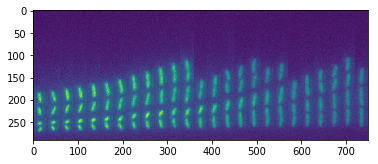

In [8]:
kymo.plot_kymograph(data['bottom/channel_RFP/11'][:])

In [3]:
class dask_controller:
    def __init__(self,n_workers=6,local=True,queue="short",\
                 walltime='01:30:00',cores=1,processes=1,memory='6GB'):
        self.local = local
        self.n_workers = n_workers
        self.walltime = walltime
        self.queue = queue
        self.processes = processes
        self.memory = memory
        self.cores = cores
    def writedir(self,directory):
        if not os.path.exists(directory):
            os.makedirs(directory)
    def startdask(self):
        if self.local:
            self.daskclient = Client()
            self.daskclient.cluster.scale(self.n_workers)
        else:
            # note the specifed walltime, don't use too much or too little, 01:30:00 is a good baseline, 
            # you just need enough time to finish 'gathering' to props_all before the jobs die
            # you can always spin up more jobs later
            # you will launch many jobs, so you don't need multiple processes, a lot of ram or multiple threads
            self.daskcluster = SLURMCluster(queue=self.queue,walltime=self.walltime,\
                                   processes=self.processes,memory=self.memory,
                                  cores=self.cores)
            self.workers = self.daskcluster.start_workers(self.n_workers)
            self.daskclient = Client(self.daskcluster)
    def printprogress(self):
        complete = len([item for item in self.futures if item.status=="finished"])
        print(str(complete) + "/" + str(len(self.futures)))
        
    def writekymo(self,numfovs,all_channels,input_path,output_path,temp_path):
        self.writedir(output_path)
        fovs = list(range(numfovs))
        def genkymo(fovnum,all_channels=all_channels,input_path=input_path,output_path=output_path,temp_path=temp_path):
            full_input_path = input_path + "/fov_" + str(fovnum) + ".hdf5"
            full_output_path = output_path + "/fov_" + str(fovnum) + ".hdf5"
            full_temp_path = temp_path + "/fov_" + str(fovnum) + "/"
            writedir(full_temp_path)
            kymo = kymograph(full_input_path,full_output_path,full_temp_path,all_channels,270,20,30,t_chunk=25)
            kymo.generate_kymograph()
        self.futures = self.daskclient.map(genkymo,fovs)

In [4]:
# input_path = '/n/groups/paulsson/Daniel/Image_analysis_pipeline/tiff_extraction/test_out_4/fov_70.hdf5'
# temp_path = '/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs/tempfiles/'
# output_path = '/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs/test_output.hdf5'
# kymo = kymograph(input_path,output_path,temp_path,["channel_BF","channel_RFP"],270,20,30,t_chunk=25)

def writedir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

all_channels = ["channel_BF","channel_RFP"]
input_path = "/n/groups/paulsson/Daniel/Image_analysis_pipeline/tiff_extraction/test_out_4"
output_path = "/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs/output"
temp_path = "/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs/tempfiles"

writedir(output_path)

def genkymo(fovnum,all_channels=all_channels,input_path=input_path,output_path=output_path,temp_path=temp_path):
    full_input_path = input_path + "/fov_" + str(fovnum) + ".hdf5"
    full_output_path = output_path + "/fov_" + str(fovnum) + ".hdf5"
    full_temp_path = temp_path + "/fov_" + str(fovnum) + "/"
    writedir(full_temp_path)
    kymo = kymograph(full_input_path,full_output_path,full_temp_path,all_channels,270,20,30,t_chunk=25)
    kymo.generate_kymograph()

#### Brief test and memory usage benchmark.

In [7]:
%load_ext memory_profiler
%memit genkymo(40)

/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs/tempfiles/fov_40/
/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs/output/fov_40.hdf5
peak memory: 881.91 MiB, increment: 754.96 MiB


In [5]:
genkymo(40)

/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs/tempfiles/fov_40/


Memory reqs are bad...wont scale well with t...

In [6]:
kymo_controller = dask_controller(walltime='00:30:00',local=False,n_workers=30,memory='2GB')
kymo_controller.startdask()
kymo_controller.daskcluster.start_workers()

In [8]:
kymo_controller.daskclient

Client Scheduler: tcp://10.120.17.15:56082 Dashboard: http://10.120.17.15:8787/status,Cluster Workers: 9 Cores: 9 Memory: 18.00 GB


In [9]:
all_channels = ["channel_BF","channel_RFP"]
input_path = "/n/groups/paulsson/Daniel/Image_analysis_pipeline/tiff_extraction/test_out_4"
output_path = "/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs/output"
temp_path = "/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs/tempfiles"
kymo_controller.writekymo(80,["channel_BF","channel_RFP"],input_path,output_path,temp_path)

In [17]:
kymo_controller.printprogress()

79/80


In [ ]:
props = kymo_controller.daskclient.gather(writer1.futures) #this will hang until all futures are done

In [ ]:
kymo_controller.daskcluster.stop_workers(writer1.workers)  #this is still not working
kymo_controller.daskcluster.stop_all_jobs() #this seems to work